<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот Ноутбук является Примером/Шаблоном (Baseline) к этому соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

In [3]:
import numpy as np                    # линейная алгебра
import pandas as pd                   # обработка данных
import sys                            # специфичные параметры и функицц
import re                             # регулярные выражения
import requests                       # получение данных с интернет-ресурсов
from bs4 import BeautifulSoup         # парсинг данных с интернет-ресурсов
from datetime import timedelta        # работа со временем
from unicodedata import normalize     # обработка "грязных" строк

# алгоритмы разделения выборок, обучения и оптимизаци моделей
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder

# модели
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostRegressor, Pool, cv
from sklearn.base import clone

#визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint


In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.20.1


In [5]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Setup

In [6]:
VERSION    = 16
#DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключил к ноутбуку внешний датасет
#DIR_TEST   = '../input/sf-dst-car-price-prediction/'
DATA_DIR = './data'
VAL_SIZE   = 0.20   # 20%
RANDOM_SEED = 42    # фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы!

pd.set_option('display.max_rows', 30) # показывать больше строк
pd.set_option('display.max_columns', 30) # показывать больше колонок

# Data

In [7]:
#!ls '../input'

In [8]:
# импорт
train = pd.read_csv(DATA_DIR +'/all_auto_ru_09_09_2020.csv')
test = pd.read_csv(DATA_DIR +'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')



# PreProcessing

In [14]:
# Полезные ф-ии

# ф-я для приведения типа кузова к стандартному виду ( например, внедорожник 5 дв -> внедорожник и т.д.)
def norm_body_type(string):
    m = re.search('седан|внедорожник|хэтчбек|лифтбек|универсал|минивэн|купе|компактвэн|пикап|родстер|кабриолет|фургон|лимузин|микровэн|тарга',\
                      string)
    if m:
        return m.group(0)
    else:
        return string


# ф-я принимает серию возвращает кортеж :
# [0]-25% перцентиль серии
# [1]-75% перцентиль серии
# [2]-IQR
# [3]-нижняя граница выбросов
# [4]-верхняя граница выбросов
def get_bounds(ser):
    perc25 = ser.quantile(0.25)
    perc75 = ser.quantile(0.75)
    IQR = perc75-perc25

    return (perc25, perc75, IQR, perc25-1.5*IQR, perc75+1.5*IQR)

# ф-я выводит 25% и 75% перцентили серии, IQR, границы выбросов, рисует гистограмму по серии, исключая выбросы
def print_hist(ser):
    bounds = get_bounds(ser)

    print(
        '25-й перцентиль: {},'.format(bounds[0]),
        '75-й перцентиль: {},'.format(bounds[1]),
        "IQR: {},".format(bounds[2]),
        "Границы выбросов: [{L},{H}].".format(L=bounds[3], H=bounds[4])
    )

    ser.loc[ser.between(bounds[3], bounds[4])].hist(
        bins=16, range=(ser.min(), ser.max()), label='IQR')

    plt.legend()

# ф-я возвращает серию без выбросов, для определения границ выбросов используется get_bounds()   
def filter_emissions(ser):
    bounds = get_bounds(ser)
    return ser[ser.between(bounds[3], bounds[4])]

# ф-я отрисовки боксплота
def get_boxplot(column):
    fig,ax=plt.subplots(figsize=(14,4))
    sns.boxplot(x=column, y='price',
               data=data_eda.loc[data_eda.loc[:,column].isin(data_eda.loc[:,column].value_counts().index[:10])],
               ax=ax
               )
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for '+ column)
    plt.show()

# ф-ю для замены названия цвета в его кодировку в RGB с помощью созданного датасета colorFrame
def get_color_code(val):
    try:
        if (re.search('й$',val)):
            return colorFrame[colorFrame.colorName == val].colorCode.item()
        else:
            return val
    
    except TypeError:
        print(val)
    
# ф-я для корректного заполнения колонок EngineDisplacement, enginePower из колонки name, т.к. они очень сильно замусорены
# значение 1.6 типа float будут превращены в 16 int, т.к. с int работать проще, а для модели не принципиально абсолютное значение, важны их соотношения
def EngineClean(row):
    d = re.search('\d\.\d',row['name'])
    p = re.search('\d+(?= л.с.)',row['name'])
    pe = re.search('\d+(?= кВт)',row['name'])
    
    if d:
        row['engineDisplacement'] = d[0].replace('.','')
    else:            
        row['engineDisplacement'] = "not found by else"
    if p:
        row['enginePower'] = p[0]
    elif pe:
        val = round(int(pe[0]) * 1.36, 0)
        row['enginePower'] =str(val).replace('.0','')
    else:
        row['enginePower'] = "not found by else"
    return row

# ф-я переводит строковое представление справочника с датой покупки авто последним собственником в кол-во дней владения
def get_ownerShipTime(string):
    #отсчетная дата - сентябрь 2020 - дата среза датасета
    end_date = pd.to_datetime('20200901', format='%Y%m%d', errors='ignore')
    try:
        sd = eval(string)
        if sd:
            # в случае, если дата задана в строковом представлении справочника
            res = (end_date - pd.to_datetime(str(sd['year'])+str(sd['month']), format='%Y%m')).days
    except:
        res = string
    # в случае, если 
    if string=='0':
        res = '0'
    # в случае, если дата указана в формате x год/года/лет и y месяц(а/ев), все случаи себя взаимоисключают
    ym_match = re.search('(?P<years>\d+) (год|года|лет) и (?P<months>\d+) месяц',string)
    y_match = re.search('(?P<years>\d+) (год|года|лет)$',string)
    m_match = re.search('^(?P<months>\d+) (месяц|месяца|месяцев)',string)
    
    # к сожалению, в конструкторе timedelta нет параметров для задания кол-ва лет и месяцев, используем, что есть
    if ym_match :
        res = timedelta(weeks=int(ym_match.group('years'))*52, days=int(ym_match.group('months'))*30).days
        
    if y_match:
        res = timedelta(weeks=int(y_match.group('years'))*52).days
        
    if m_match:
        res = timedelta(days=int(m_match.group('months'))*30).days
    
    return res
    

###### ИМеем 2 датасета с разным набором колонок, Исправим это:

In [15]:
# для удобства переименуем колонки датасетов в единый формат: английский с Большой буквы, 
# в словосочетаниях, также, каждое слово с большой буквы
train.rename(columns={
                   'Комплектация': 'equipment', 
                   'Привод': 'driveWheels', 
                   'Руль' :'rudder', 
                   'Владельцы' :'numOwners',
                   'ПТС' :'PTS',
                   'Владение' :'ownershipTime'
                  }, inplace = True)

test.rename(columns={
                    'Владельцы' :'numOwners',
                    'Владение' :'ownershipTime',
                    'ПТС' :'PTS',
                    'Привод': 'driveWheels',
                    'Руль' :'rudder',
                    'model_name' : 'model'
                    }, inplace = True)
    
    
# уберем колонки в train : 
    #состояние - все пустые,
    #Таможня - всегда True,
    #name - содержит сумму полей объем, мощность двигателя, привод, трансмиссия, которые на 99,9% заполнены в датасете
    #equipment - сложно обрабатывать, у каждого произв-ля, в разных временных интервалах разная линейка комплектаций
    #vehicleConfiguration - содержит сумму уже имющихся в наличии полей которые на 99,9% заполнены в датасете
    #start_date - пока не вижу практического смысла (в тестовых данных нет такого поля)
    #description - пока не вижу практического смысла         
    
train.drop(['Состояние','Таможня','hidden','equipment','vehicleConfiguration','start_date',\
           'description'], axis=1, inplace=True)

# уберем колонки в test : 
    #car_url - не несет практического смысла
    #состояние - всегда Не требует ремонта,
    #Таможня - всегда растаможен,
    #name - содержит сумму полей объем, мощность двигателя, привод, трансмиссия, которые на 99,9% заполнены в датасете
    #complectation_dict - сложно обрабатывать, у каждого произв-ля, в разных временных интервалах разная линейка комплектаций
    #description -  пока не вижу практического смысла
    #image - пока не вижу практического смысла
    #model_info - пока не вижу практического смысла
    #parsing_unixtime - пока не вижу практического смысла
    #priceCurrency - всегда RUB
    #super_gen - пока не вижу практического смысла
    #vehicleConfiguration  - содержит сумму уже имющихся в наличии полей которые на 99,9% заполнены в датасете
    #vendor - зависимость цены от региона производителя (Европа/Япония) считаем зашитой в брэнд
    

test.drop(['car_url','Таможня', 'Состояние','complectation_dict','description','equipment_dict',\
           'image','model_info','parsing_unixtime','priceCurrency','super_gen',\
          'vehicleConfiguration','vendor'], axis=1, inplace=True)


# в train датасете уберем те немногочисленные строки, которые содержат пропуски, исключительно в колонках, указанных ниже:
columnsToDropNa = ['bodyType','modelDate','numberOfDoors','vehicleTransmission',\
                   'engineDisplacement','enginePower','price','PTS']

train.dropna(axis=0, subset=columnsToDropNa, inplace=True)

# в test датаесете такого себе позволить не можем ( не сойдется с samplesubmission), поэтому заполним единственный пропуск
# наиболее частым значением
test.loc[test.PTS.isnull(),'PTS'] = 'Оригинал'

#train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
#test = pd.read_csv(DIR_TEST+'test.csv')
#sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bodyType             34686 non-null  object
 1   brand                34686 non-null  object
 2   color                34686 non-null  object
 3   engineDisplacement   34686 non-null  object
 4   enginePower          34686 non-null  object
 5   fuelType             34686 non-null  object
 6   mileage              34686 non-null  int64 
 7   modelDate            34686 non-null  int64 
 8   model                34686 non-null  object
 9   name                 34686 non-null  object
 10  numberOfDoors        34686 non-null  int64 
 11  productionDate       34686 non-null  int64 
 12  sell_id              34686 non-null  int64 
 13  vehicleTransmission  34686 non-null  object
 14  numOwners            34686 non-null  object
 15  ownershipTime        11995 non-null  object
 16  PTS 

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88606 entries, 0 to 89377
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             88606 non-null  object 
 1   brand                88606 non-null  object 
 2   color                88606 non-null  object 
 3   fuelType             88606 non-null  object 
 4   modelDate            88606 non-null  float64
 5   name                 88606 non-null  object 
 6   numberOfDoors        88606 non-null  float64
 7   productionDate       88606 non-null  int64  
 8   vehicleTransmission  88606 non-null  object 
 9   engineDisplacement   88606 non-null  object 
 10  enginePower          88606 non-null  float64
 11  mileage              88606 non-null  int64  
 12  driveWheels          88606 non-null  object 
 13  rudder               88606 non-null  object 
 14  numOwners            75398 non-null  float64
 15  PTS                  88606 non-null 

###### Перед объединением датасетов очень важно навести порядок в колонке numOwners, в train это float64, а в test это object

In [18]:
test.numOwners = test.numOwners.apply(lambda x: normalize("NFKD", x))
test['numOwners'] = test['numOwners'].replace(to_replace={'1 владелец':1.0,'2 владельца':2.0,'3 или более':3.0})

# в train.numOwners есть пропуски, которые заполним наихудшим вариантом - 3 
# (если в объявлении не указано кол-во владельцев, более вероятно, что их там не 1 или 2)
train.numOwners.fillna(3.0,inplace=True)

# в train превратим price в int
train.price = train.price.astype(int)

###### Получили 2 датасета со схожим набором полей, пропуски, имющиеся сейчас подлежат обработке, кроме того посмотрим на содержимое полей, приведем к одному формату

In [19]:
# для удобства дальнейшей обработки, сразу соединим датасеты: 
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
data = test.append(train, sort=False).reset_index(drop=True) # объединяем

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123292 entries, 0 to 123291
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             123292 non-null  object 
 1   brand                123292 non-null  object 
 2   color                123292 non-null  object 
 3   engineDisplacement   123292 non-null  object 
 4   enginePower          123292 non-null  object 
 5   fuelType             123292 non-null  object 
 6   mileage              123292 non-null  int64  
 7   modelDate            123292 non-null  float64
 8   model                123292 non-null  object 
 9   name                 123292 non-null  object 
 10  numberOfDoors        123292 non-null  float64
 11  productionDate       123292 non-null  int64  
 12  sell_id              34686 non-null   float64
 13  vehicleTransmission  123292 non-null  object 
 14  numOwners            123292 non-null  float64
 15  ownershipTime    

###### обработка колонки bodyType

In [20]:
data['bodyType'] = data.bodyType.str.lower()
# приведем все значения из колонки bodyType датафрейма к стандартным значениям
data.bodyType = data.bodyType.apply(norm_body_type)
data.bodyType.value_counts()


седан          44927
внедорожник    44547
хэтчбек        13393
лифтбек         5630
универсал       4717
минивэн         3361
компактвэн      2563
купе            2466
пикап            895
кабриолет        257
родстер          250
фургон           230
микровэн          31
лимузин           12
тарга              9
фастбек            4
Name: bodyType, dtype: int64

###### обработка колонки Color

In [21]:
# в датасете встречаются значения колонки Color как в текстовом виде так и в виде кодировок.
# приведем все значения к кодировкам

# находим в интернете страничку с кодировками цветов
url = 'https://www.rapidtables.org/ru/web/color/RGB_Color.html'   

# парсим ее:
response = requests.get(url)    
page = BeautifulSoup(response.text, 'html.parser')  


In [22]:
# имеем 2 таблицы, основные и дополнительные цвета:
df1 = pd.read_html(str(page.find_all("table",class_='dtable')[1]))[0]
df2 = pd.read_html(str(page.find_all("table",class_='dtable')[2]))[0]

#не со всеми цветами прошло "гладко", поэтому 3-й корректировочный датасет:
df3 = pd.DataFrame({'colorName':['чёрный','зелёный','серебристый','пурпурный','жёлтый','оранжевый','золотистый'],
                  'colorCode':['000000','008000','C0C0C0','FF00FF','FFFF00','FFA500','FFD700']})

# собираем 1-й датафрейм, приводим к единому имени колонок, лишние колонки удаляем:
df1.drop(['цвет','Десятичный код(R, G, B)'],axis=1, inplace = True)
df1.rename(columns={
                    'HTML / CSS имя' :'colorName',
                    'Шестнадцатеричный код#RRGGBB' :'colorCode'
                    }, inplace = True)

# собираем 2-й датафрейм, приводим к единому имени колонок, лишние колонки удаляем:
df2.drop(['цвет','Десятичный кодR, G, B'],axis=1, inplace = True)
df2.rename(columns={
                    'Название цвета' :'colorName',
                    'Шестнадцатеричный код#RRGGBB' :'colorCode'
                    }, inplace = True)

# объединяем все датафреймы
colorFrame = df1.append(df2).append(df3).reset_index(drop=True)

# приводим в нижний регистр название цвета:
colorFrame.colorName = colorFrame.colorName.str.lower()

# удаляем мусорные решетки:
colorFrame.colorCode = colorFrame.colorCode.apply(lambda x: x.replace('# ',''))

# удаляем дубликаты
colorFrame.colorName = colorFrame.colorName.drop_duplicates()



# применяем ф-ю к колонке color
data['color'] = data.color.apply(get_color_code)
data['color'] = data.color.apply(lambda x: x.replace('#',''))

###### как итог, колонка color в едином RGB-формате

In [23]:
data['color'].value_counts()

040001    24981
FAFBFB    15672
CACECB    11260
000000    11010
97948F    10720
          ...  
FF00FF      254
800080      219
FFFF00      194
FFA500      131
FFC0CB       38
Name: color, Length: 31, dtype: int64

###### Обработка колонок engineDisplacement и enginePower

In [24]:
data = data.apply(EngineClean, axis=1)  
# проанализированы строки с "not found by else", во всех случах это электрокары, поэтому присвоим им нулевой объем
data.engineDisplacement = data.engineDisplacement.apply(lambda x: x.replace('not found by else','0'))
data.engineDisplacement = data.engineDisplacement.astype(int)
data.enginePower = data.enginePower.astype(int)

###### обработка колонки vehicleTransmission

In [25]:
# приведем все значения в одни "единицы измерения" (mechanical= механическая и т.д.)
data['vehicleTransmission'] = data['vehicleTransmission'].str.lower()
data['vehicleTransmission'] = data['vehicleTransmission'].replace(to_replace={'mechanical':'механическая',\
                                                                              'automatic':'автоматическая',\
                                                                              'robot':'роботизированная',\
                                                                              'variator':'вариатор'
                                                                             })

data['vehicleTransmission'].value_counts()

автоматическая      68311
механическая        32340
роботизированная    11663
вариатор            10978
Name: vehicleTransmission, dtype: int64

###### обработка колонки ownershipTime

In [26]:
# пустые значения заполним нулями
data.ownershipTime.fillna('0', inplace=True)

# применяем ф-ю   
data['ownershipTime'] = data['ownershipTime'].apply(get_ownerShipTime )


In [27]:
data['ownershipTime'] = data['ownershipTime'].astype(int)

###### обработка колонки PTS

In [28]:
data.PTS = data.PTS.str.lower()
data.PTS = data.PTS.replace(to_replace={'original':'оригинал','duplicate':'дубликат'})
data.PTS.value_counts()

оригинал    108329
дубликат     14963
Name: PTS, dtype: int64

###### обработка колонки rudder

In [29]:
data.rudder = data.rudder.str.lower()
data.rudder = data.rudder.replace(to_replace={'left':'левый','right':'правый'})
data.rudder.value_counts()

левый     120111
правый      3181
Name: rudder, dtype: int64

In [30]:
data.numOwners = data.numOwners.astype(int)
data.numberOfDoors = data.numberOfDoors.astype(int)
data.modelDate = data.modelDate.astype(int)


# Итого:
###### колонки fuelType, mileage, modelDate, model, numberOfDoors, productionDate, numOwners, driveWheels не требуют обработки

###### не считаю необходимым генерировать дополнительные признаки, т.к. все  объективные признаки, способные количественно и качественно охарактеризовать авто наличествуют в датасете. Имеем 20 признаков, из которых :
###### - sell_id - поле есть только в test части датафрейма для соединения с samplesubmission 
###### - price - поле есть только в train части датафрейма для обучения модели
###### - sample - признак, отделяющий test от train датафрейма 

###### т.е. в нашем распоряжении 17 признаков

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123292 entries, 0 to 123291
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             123292 non-null  object 
 1   brand                123292 non-null  object 
 2   color                123292 non-null  object 
 3   engineDisplacement   123292 non-null  int32  
 4   enginePower          123292 non-null  int32  
 5   fuelType             123292 non-null  object 
 6   mileage              123292 non-null  int64  
 7   modelDate            123292 non-null  int32  
 8   model                123292 non-null  object 
 9   name                 123292 non-null  object 
 10  numberOfDoors        123292 non-null  int32  
 11  productionDate       123292 non-null  int64  
 12  sell_id              34686 non-null   float64
 13  vehicleTransmission  123292 non-null  object 
 14  numOwners            123292 non-null  int32  
 15  ownershipTime    

# EDA
###### следует отметить, что датасет (как train так и test) содержат совершенно не прогнозируемые по цене варианты авто, их можно разделить на 2 группы:
 ###### 1) раритет
   ###### - предложений будет немного, модель не обучится полноценно
   ###### - цена раритетных авто очень сильно зависит от их состояния, которое невозможно оценить по количественным и качественным харак-кам 
   
 ###### 2) сегмент эксклюзивных авто
   ###### -  опять же немного экземпляров для обучения
   ###### - опять же на цену может влиять совершенно случайная харак-ка (золотой руль или машина внука Майкла Джексона)
   
###### Исходя из постановки задачи, нам нужен сервис, который поможет перекупщикам более выгодно перепродать авто, а значит внимание стоит сфокусировать на повседневных авто:
   ###### - раритет отбросим грубо по году выпуска авто, будем рассматривать только авто, выпущенные с 2000 года (для перекупов более старые авто - сплошная головная боль, это уже скорее музейные экспонаты или доноры для их восстановления)
   ###### - эксклюзив отбросим, руководствуясь определением выбросов по цене
   ###### - также исключим из выборки авто, имеющие слишком большой пробег (также, руководятвуясь определением выброса ), т.к. такие авто также не оценить по параметрам
# _____________________________________________________________
   

###### На графике ниже можно увидеть взрывной рост автомобильной промышленности с 2000 года. Объявления о продаже авто старше 2000 г.в. будем исключать из train датасета

<AxesSubplot:>

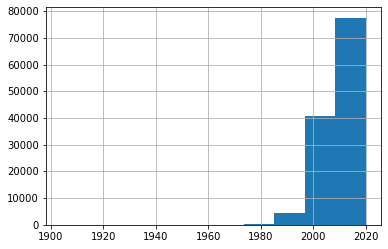

In [32]:
data.productionDate.hist()

###### для показательности гистограммы, ограничим цену 7 млн. р., видим, что подавляющее большинство авто находится в ценовой категории до 1 млн.р.

<AxesSubplot:>

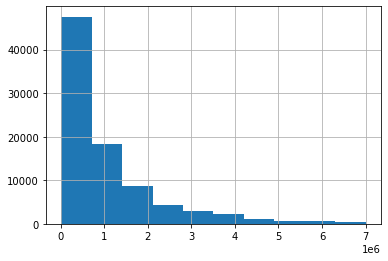

In [33]:
data[data.price<7000000].price.hist()

###### Для обучения модели удем использовать объявления до 3.1 млн. р.

25-й перцентиль: 350000.0, 75-й перцентиль: 1450000.0, IQR: 1100000.0, Границы выбросов: [-1300000.0,3100000.0].


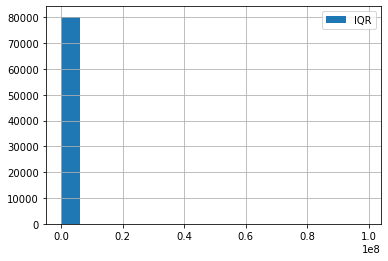

In [34]:
print_hist(data.price)

###### Для обучения модели будем использовать объявления с пробегом до 400 тыс.км.

25-й перцентиль: 70000.0, 75-й перцентиль: 200000.0, IQR: 130000.0, Границы выбросов: [-125000.0,395000.0].


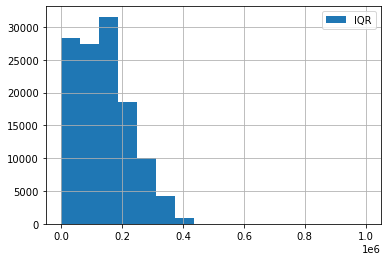

In [35]:
print_hist(data.mileage)

###### Оценим влияние категориальных признаков на цену

In [36]:
# для оценки будем использовать train датасет с отфильтрованными выбросами
data_eda = data.copy()
data_eda = data_eda[data_eda['sample'] == 1]
data_eda = data_eda[data_eda.productionDate > 1999]
data_eda = data_eda[data_eda.price < 3100000]
data_eda = data_eda[data_eda.mileage <395001]



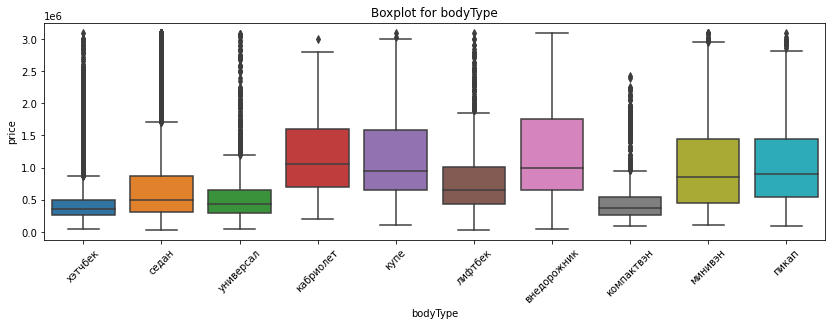

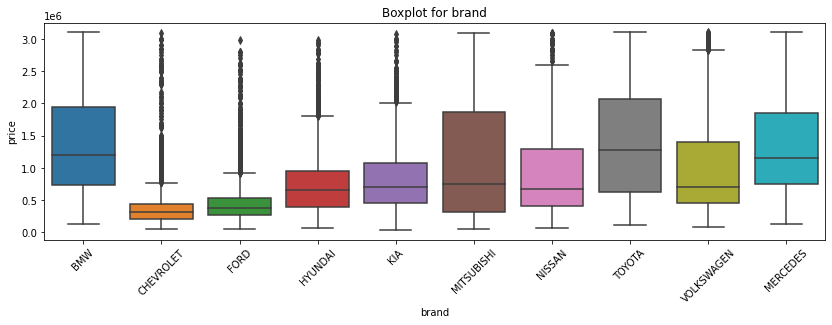

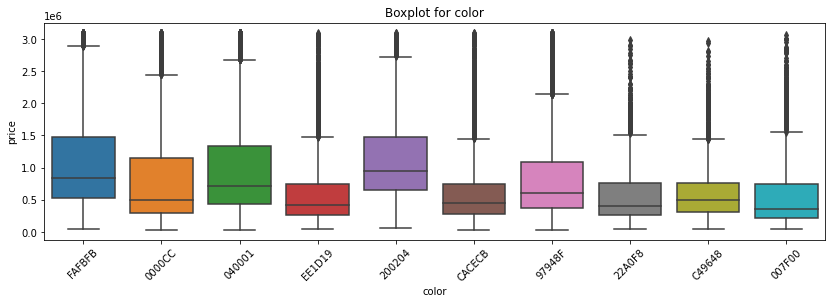

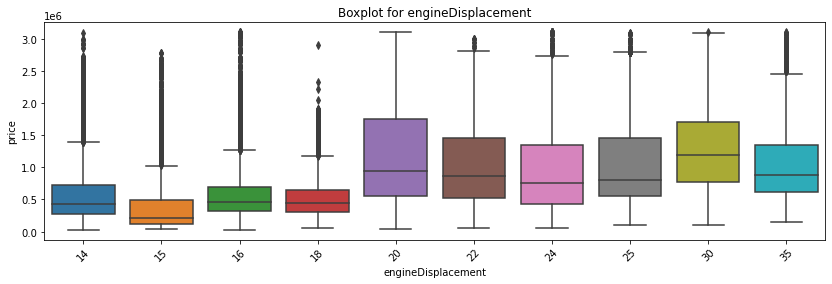

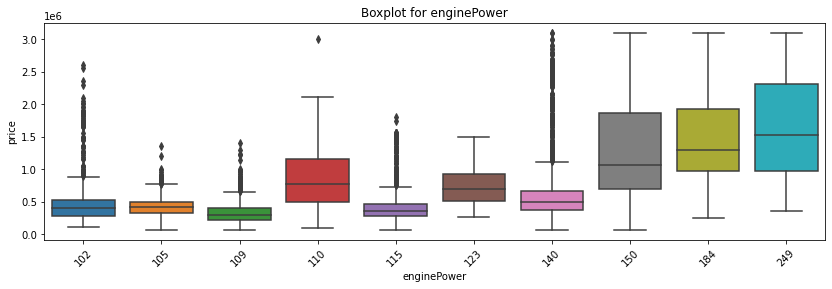

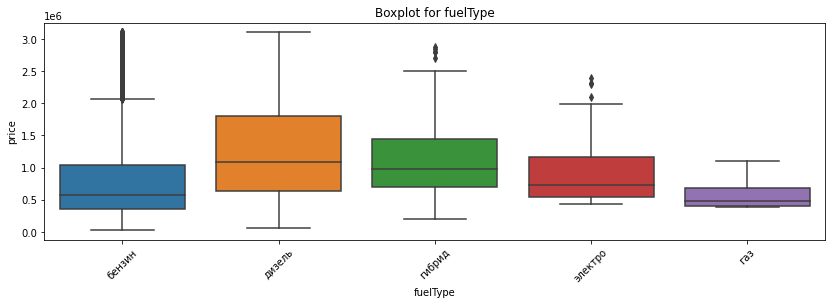

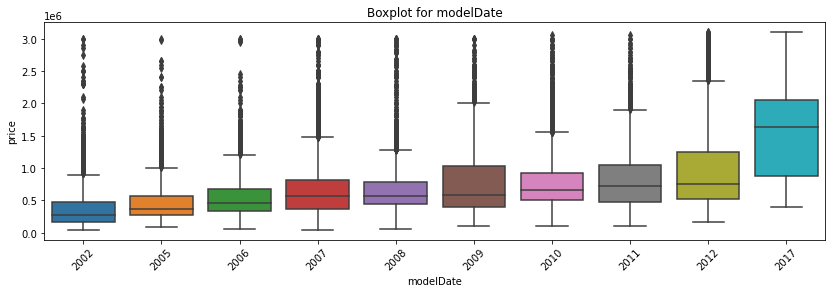

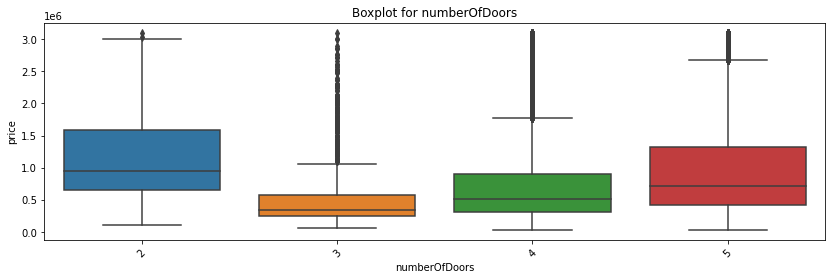

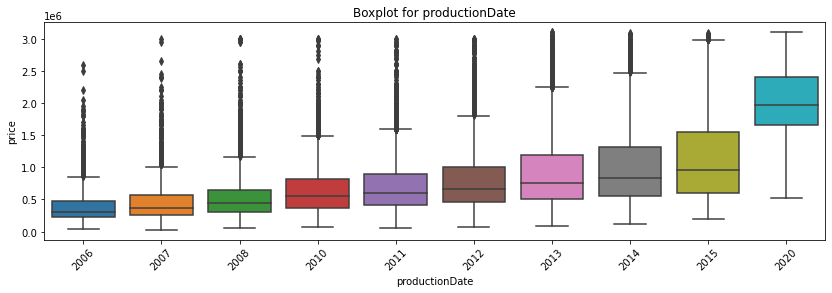

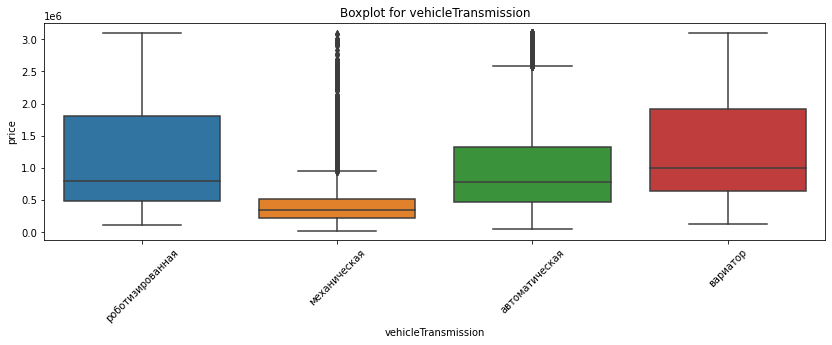

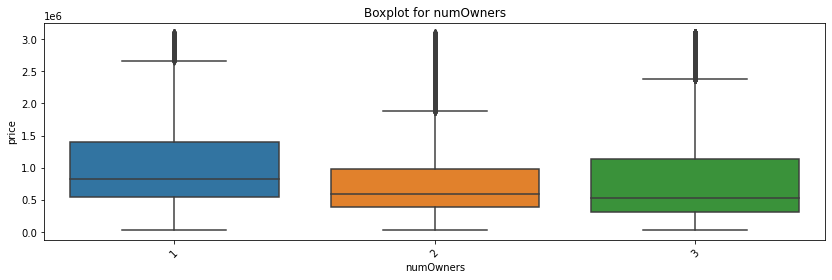

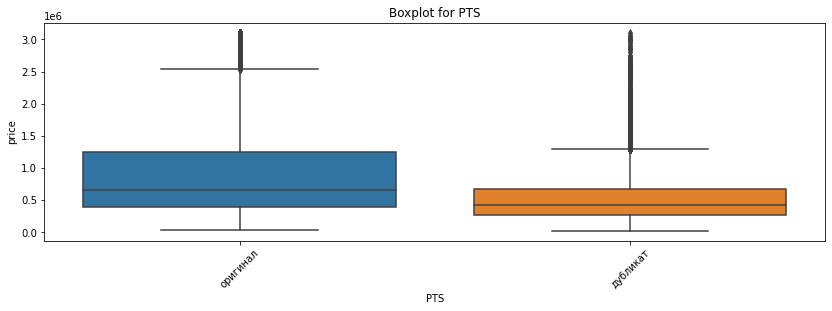

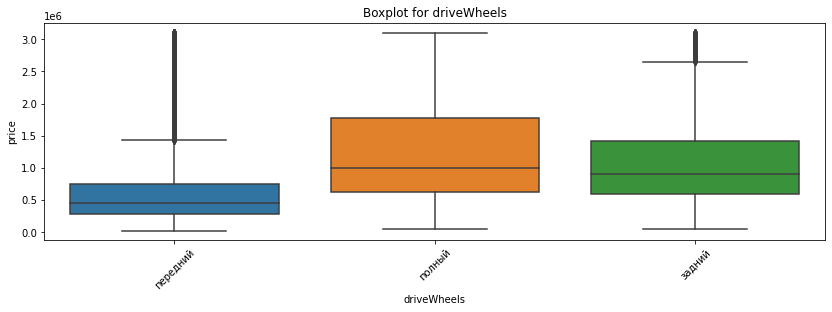

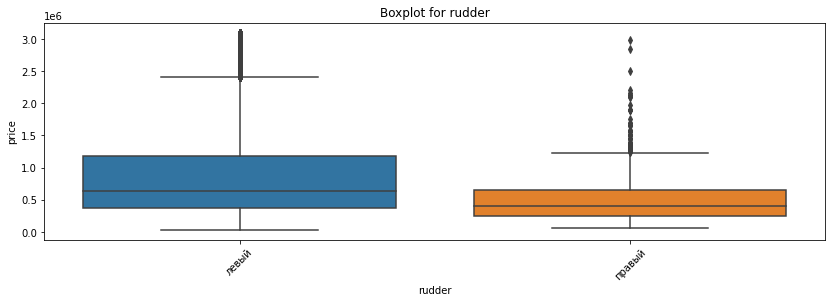

In [37]:
for col in ['bodyType','brand','color','engineDisplacement','enginePower','fuelType','modelDate',\
            'numberOfDoors','productionDate','vehicleTransmission','numOwners','PTS','driveWheels','rudder']:
    get_boxplot(col)

### Выводы:
###### 1)  кабриолет, купе и внедорожник - самые дорогие кузова, хэтчбэк и компактвэн - самые дешевые
###### 2) BMW, MITSUBISHI, TOYOTA, MERCEDES - самые дорогие брэнды, CHEVROLET и FORD - самые дешевые
###### 3) Белый и черный цвета ценятся более всего
###### 4) ожидаемо, моторы объемом от 2л. ценятся больше
###### 5) моторы 150 и 250 л.с. хорошо ценятся
###### 6) ожидаемо, дизельные гибридные и электро двигатели дороже, т.к. наиболее сложны (в случае с электро - технологичнее авто в целом)
###### 7) 3-летние авто ценятся лучше всех (на момент 2020)
###### 8) ожидаемо 2 дверные авто (купе, кабриолеты) ценятся более 
###### 9) за 5 лет авто теряет половину цены...
###### 10) ожидаемо, механика ценится менее всех остальных трансмиссий
###### 11) ожидаемо, больше ценится, когда 1 владелец
###### 12) ожидаемо, больше ценится, когда ПТС оригинал
###### 13) ожидаемо, полный привод ценится больше всего, а задний больше переднего
###### 13) ожидаемо, леворульные авто дороже праворульных


In [38]:
for colum in ['bodyType','brand','color','engineDisplacement','enginePower','fuelType','modelDate','model',\
            'numberOfDoors','vehicleTransmission','numOwners','PTS','driveWheels','rudder']:
    data[colum] = data[colum].astype('category').cat.codes

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123292 entries, 0 to 123291
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             123292 non-null  int8   
 1   brand                123292 non-null  int8   
 2   color                123292 non-null  int8   
 3   engineDisplacement   123292 non-null  int8   
 4   enginePower          123292 non-null  int16  
 5   fuelType             123292 non-null  int8   
 6   mileage              123292 non-null  int64  
 7   modelDate            123292 non-null  int8   
 8   model                123292 non-null  int16  
 9   name                 123292 non-null  object 
 10  numberOfDoors        123292 non-null  int8   
 11  productionDate       123292 non-null  int64  
 12  sell_id              34686 non-null   float64
 13  vehicleTransmission  123292 non-null  int8   
 14  numOwners            123292 non-null  int8   
 15  ownershipTime    

In [40]:
# обратно делим train и test датасеты, в train избавляемся от выбросов
X = data.query('sample == 1').drop(['sample','sell_id','name'], axis=1)
X = X[X.productionDate>1999]
X = X[X.price<3100000]
X = X[X.mileage<395001]
# фиксируем целевую переменную в train датасете уже после удаления выбросов, чтобы строки не "поехали"
y = X['price']
# удаляем из train датасета целевую переменную 
X = X.drop(['price'], axis = 1)
# в test датасете просто удаляем колонку sample
X_sub = data.query('sample == 0').drop(['sample','price','name'], axis=1)

In [41]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73860 entries, 34989 to 123291
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   bodyType             73860 non-null  int8 
 1   brand                73860 non-null  int8 
 2   color                73860 non-null  int8 
 3   engineDisplacement   73860 non-null  int8 
 4   enginePower          73860 non-null  int16
 5   fuelType             73860 non-null  int8 
 6   mileage              73860 non-null  int64
 7   modelDate            73860 non-null  int8 
 8   model                73860 non-null  int16
 9   numberOfDoors        73860 non-null  int8 
 10  productionDate       73860 non-null  int64
 11  vehicleTransmission  73860 non-null  int8 
 12  numOwners            73860 non-null  int8 
 13  ownershipTime        73860 non-null  int32
 14  PTS                  73860 non-null  int8 
 15  driveWheels          73860 non-null  int8 
 16  rudder           

In [42]:
X_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 0 to 34685
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             34686 non-null  int8   
 1   brand                34686 non-null  int8   
 2   color                34686 non-null  int8   
 3   engineDisplacement   34686 non-null  int8   
 4   enginePower          34686 non-null  int16  
 5   fuelType             34686 non-null  int8   
 6   mileage              34686 non-null  int64  
 7   modelDate            34686 non-null  int8   
 8   model                34686 non-null  int16  
 9   numberOfDoors        34686 non-null  int8   
 10  productionDate       34686 non-null  int64  
 11  sell_id              34686 non-null  float64
 12  vehicleTransmission  34686 non-null  int8   
 13  numOwners            34686 non-null  int8   
 14  ownershipTime        34686 non-null  int32  
 15  PTS                  34686 non-null 

In [43]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   sell_id  34686 non-null  int64
 1   price    34686 non-null  int64
dtypes: int64(2)
memory usage: 542.1 KB


In [48]:
X.shape, y.shape, X_sub.shape, sample_submission.shape

((73860, 17), (73860,), (34686, 18), (34686, 2))

# Как будем оценивать модель?
###### Наша задача сводится к предсказанию стоимости авто, а значит это задача регрессии, для оценки качества модели будем использовать метрику MAPE, эта метрика показывает, на сколько процентов в среднем наше предсказание отклоняется от реального значения.

In [49]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

## Train Split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [51]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [52]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 61.10%


# # Model 2 : Решающее дерево

In [307]:
DecTree = DecisionTreeRegressor(max_depth=3, random_state=RANDOM_SEED)
DecTree.fit(X_train, y_train,)
DecTree_predict = DecTree.predict(X_test)
print(f"Точность модели Решающее дерево по метрике MAPE до оптимизиации: {(mape(y_test, DecTree_predict))*100:0.2f}%")

Точность модели Решающее дерево по метрике MAPE до оптимизиации: 39.66%


In [308]:
max_depth = [int(x) for x in np.linspace(10, 30, num = 20)]
max_leaf_nodes = [int(x) for x in np.linspace(2, 30, num = 30)]
max_depth.append(None)
max_features = ['auto', 'sqrt', 'log2']
min_samples_leaf = [2,3,4,5,6,7,8]

random_grid = {'max_depth': max_depth,'max_features':max_features,'min_samples_leaf':min_samples_leaf}

DecTree = DecisionTreeRegressor(random_state=RANDOM_SEED)
DecTree_opt = RandomizedSearchCV(estimator=DecTree, param_distributions=random_grid, n_iter=100, 
                               cv=3, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
DecTree_opt.fit(X_train, y_train)
DecTree_opt.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 23}

In [309]:
DecTree_opt_predict = DecTree_opt.predict(X_test)
print(f"Точность модели Решающее дерево по метрике MAPE после оптимизации: {(mape(y_test, DecTree_opt_predict))*100:0.2f}%")

Точность модели Решающее дерево по метрике MAPE после оптимизации: 13.95%


# # Model 3 : Случайный лес

In [310]:
RandomForest = RandomForestRegressor(random_state = 42)
RandomForest.fit(X_train, y_train,)
RandomForest_predict = RandomForest.predict(X_test)
print(f"Точность модели Случайный лес по метрике MAPE: {(mape(y_test, RandomForest_predict))*100:0.2f}%")

Точность модели Случайный лес по метрике MAPE: 11.84%


###### Выполнить подбор наилучших для случайного леса параметров так и не удалось (не удивительно, ведь объем вычислений гигантский, попробуем воспользоваться более оптимальными алгоритмами

# # Model 4: AdaBoost on Random Forest

In [311]:
AdaBoost_RF = AdaBoostRegressor(base_estimator=RandomForest)
AdaBoost_RF.fit(X_train, y_train)
AdaBoost_RF_predict = AdaBoost_RF.predict(X_test)
print(f"Точность модели AdaBoost по метрике MAPE: {(mape(y_test, AdaBoost_RF_predict))*100:0.2f}%")

Точность модели AdaBoost по метрике MAPE: 14.66%


###### Подбор параметров, также не представляется возможным

# # Model 5: AdaBoost on DecisionTree

In [312]:
DecTree = DecisionTreeRegressor(random_state=RANDOM_SEED, min_samples_leaf=6,max_features='auto',max_depth=18)

AdaBoost_DT = AdaBoostRegressor(base_estimator=DecTree)
AdaBoost_DT.fit(X_train, y_train)
AdaBoost_DT_predict = AdaBoost_DT.predict(X_test)
print(f"Точность модели AdaBoost по метрике MAPE: {(mape(y_test, AdaBoost_DT_predict))*100:0.2f}%")

Точность модели AdaBoost по метрике MAPE: 13.25%


###### Подбор параметров, также не представляется возможным

# # Model 5: Градиентный бустинг

In [314]:
GradBoost = GradientBoostingRegressor()
GradBoost.fit(X_train, y_train)
GradBoost_predict = GradBoost.predict(X_test)
print(f"Точность модели Градиентный бустинг по метрике MAPE: {(mape(y_test, GradBoost_predict))*100:0.2f}%")

Точность модели Градиентный бустинг по метрике MAPE: 18.70%


###### Выполнить подбор оптимальных параметров не имеет смысла, т.к. модель CatBoost (по-сути тот же градиентный бустинг) показала себя сильно лучше даже без подбора параметров, в дальнейшем для стакинга буду использовать именно CatBoost

# # Model 6 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

In [53]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [54]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 11.30%


###### попробуем логарифмировать таргет и применить более оптимальные пар-ры:

In [67]:
CatBoost = CatBoostRegressor(iterations = 1000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric='MAE',
                          one_hot_max_size = 15,
                          learning_rate=0.1,
                          depth = 10,
                          l2_leaf_reg = 1,
                          silent=True
                         )

CatBoost.fit(X_train, np.log(y_train),
         cat_features=['brand','color','fuelType','model','vehicleTransmission','PTS','driveWheels','rudder'],
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         
         plot=True
         )


CatBoost.save_model('catboost_single_model_2_baseline.model')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [366]:
CatBoost_predict = np.exp(CatBoost.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, CatBoost_predict))*100:0.2f}%")

Точность модели по метрике MAPE: 10.78%


###### выполним кроссвалидацию и подберем параметры:

In [361]:
CatBoost1 = CatBoostRegressor(random_seed = RANDOM_SEED)

params = {"iterations": 1000,
          "depth": 10,
          "l2_leaf_reg":1,
          "learning_rate":0.1,
          "loss_function": "MAPE",
          "verbose": False}
cv_dataset = Pool(data=X_train,
                  label=y_train)
scores = cv(cv_dataset,
            params,
            fold_count=3, 
            plot="True")




MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.2763776197
bestIteration = 999

Training on fold [1/3]

bestTest = 0.2750604302
bestIteration = 988

Training on fold [2/3]

bestTest = 0.2622989834
bestIteration = 997



In [358]:
CatBoost_opt = CatBoostRegressor(random_seed = RANDOM_SEED, eval_metric='MAPE', custom_metric='MAE',
                          one_hot_max_size = 15,
                          silent=True)

              
grid = {'learning_rate': [0.05,0.1],
        'depth': [5,10,20],
        'l2_leaf_reg': [1,1.1],
        'iterations':[500,1000]}

grid_search_result = CatBoost_opt.grid_search(grid, X=X_train, y=y_train, plot=True)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.1430514413
bestIteration = 499

0:	loss: 0.1430514	best: 0.1430514 (0)	total: 4.51s	remaining: 1m 43s

bestTest = 0.1293725431
bestIteration = 499

1:	loss: 0.1293725	best: 0.1293725 (1)	total: 8.82s	remaining: 1m 36s

bestTest = 0.1444746547
bestIteration = 499

2:	loss: 0.1444747	best: 0.1293725 (1)	total: 13s	remaining: 1m 31s

bestTest = 0.129279847
bestIteration = 499

3:	loss: 0.1292798	best: 0.1292798 (3)	total: 17s	remaining: 1m 24s

bestTest = 0.1282993733
bestIteration = 999

4:	loss: 0.1282994	best: 0.1282994 (4)	total: 25.4s	remaining: 1m 36s

bestTest = 0.1192852833
bestIteration = 999

5:	loss: 0.1192853	best: 0.1192853 (5)	total: 33.6s	remaining: 1m 40s

bestTest = 0.1291590339
bestIteration = 999

6:	loss: 0.1291590	best: 0.1192853 (5)	total: 41.8s	remaining: 1m 41s

bestTest = 0.1184222002
bestIteration = 999

7:	loss: 0.1184222	best: 0.1184222 (7)	total: 50.3s	remaining: 1m 40s

bestTest = 0.1168525706
bestIteration = 499

8:	loss: 0.1168526	best: 0.1168

#### Попробуем stacking
###### В stacking я буду использовать :
###### во-первых принципиально разные модели (CatBoost это глубокое развитие градиентного бустинга)
###### во-вторых модели с наилучшим MAPE
###### это модели: бустинг решающего дерева, случайный лес и Catboost

In [56]:
def compute_meta_feature(clf, XX_train, XX_test, yy_train, cv):
    """
    Computes meta-features using the classifier.
    
    :arg clf: scikit-learn classifier
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    X_meta_train = np.zeros_like(yy_train, dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(XX_train):
        X_fold_train, X_fold_predict = XX_train.iloc[train_fold_index], XX_train.iloc[predict_fold_index]
        y_fold_train = yy_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_clf.predict(X_fold_predict)
        
    meta_clf = clone(clf)
    meta_clf.fit(XX_train, yy_train)
    
    X_meta_test = meta_clf.predict(XX_test)
    
    return X_meta_train, X_meta_test

def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
    """
    Generates metafeatures using a list of classifiers.
    
    :arg classifiers: list of scikit-learn classifiers
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test

def compute_metric(clf, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    return mape(y_test, y_test_pred)*100


DecTree = DecisionTreeRegressor(random_state=RANDOM_SEED, min_samples_leaf=6,max_features='auto',max_depth=18)
cv = KFold(n_splits=10, shuffle=True)

cover_X_train, cover_X_test, cover_y_train, cover_y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=RANDOM_SEED)




In [59]:
cover_X_train.shape, cover_X_test.shape, cover_y_train.shape, cover_y_test.shape

((36930, 17), (36930, 17), (36930,), (36930,))

In [60]:
stacked_features_train, stacked_features_test = generate_meta_features([
    AdaBoostRegressor(base_estimator=DecTree),
    RandomForestRegressor(random_state = 42),  
    CatBoostRegressor(iterations = 1000, random_seed = RANDOM_SEED, eval_metric='MAPE',custom_metric='MAE',silent = True)
], cover_X_train, cover_X_test, cover_y_train.values, cv)

  0%|          | 0/3 [00:00<?, ?it/s]

In [62]:
stacked_features_train.shape,y_train.shape,stacked_features_test.shape,y_test.shape

((36930, 3), (59088,), (36930, 3), (14772,))

In [65]:
total_features_train = np.hstack([cover_X_train, stacked_features_train])
total_features_test = np.hstack([cover_X_test, stacked_features_test])
clf = RandomForestRegressor(random_state = 42)
print(f"Точность модели по метрике MAPE: {compute_metric(clf, stacked_features_train, cover_y_train, stacked_features_test, cover_y_test):0.2f}%")


Точность модели по метрике MAPE: 12.14%


# Итого:
###### Наилучший результат показала модель CatBoost на оптимизированных параметрах, MAPE = 10.78%
###### Также стоит отметить модель RandomForest, показавшую на стандартных параметрах близкий к тому же значению MAPE: 11.84%

# Submission

In [69]:
# попробуем засабмитить лучшую модель (CatBoost)
X_sub = X_sub.drop(['sell_id'], axis = 1)

predict_test = np.exp(CatBoost.predict(X_test))
predict_submission = np.exp(CatBoost.predict(X_sub))

sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,5.864639e+05
1,1100549428,8.243081e+05
2,1100658222,8.965452e+05
3,1100937408,6.536551e+05
4,1101037972,6.551489e+05
5,1100912634,8.023299e+05
6,1101228730,6.269517e+05
7,1100165896,3.848324e+05
8,1100768262,1.653385e+06
9,1101218501,7.973508e+05


###### 202 позиция на ЛБ, score = 19.16

In [ ]:
# посмотрим, вдруг стакинг покажет себя лучше на лидерборде
stacked_features_train, stacked_features_sub = generate_meta_features([
    AdaBoostRegressor(base_estimator=DecTree),
    RandomForestRegressor(random_state = 42),  
    CatBoostRegressor(iterations = 1000, random_seed = RANDOM_SEED, eval_metric='MAPE',custom_metric='MAE',silent = True)
], cover_X_train, X_sub, cover_y_train.values, cv)

clf = RandomForestRegressor(random_state = 42)
clf.fit(stacked_features_train, cover_y_train)
predict_submission_stacking = clf.predict(stacked_features_sub)
sample_submission['price'] = predict_submission_stacking
sample_submission.to_csv(f'submission_2_v{VERSION}_stacking.csv', index=False)
sample_submission.head(10)

###### Не показал, score = 22.5